# DS3000 Day 16

Nov 4 2022

Admin:
- Qwickly attendance
- Project **next steps:**
    - Meet with TA guide (should have received an email)
    - Schedule a meeting with me (not required, but highly recommended): [Calendly Link](https://calendly.com/e-gerber/project-meeting)
    - Data and Analysis Plan (example on Canvas): **Due Nov. 8**
- HW 6 **Due Tonight**
- HW 7 posted later tonight, will be **Due Nov. 18**
- Lab 4 next Tuesday (and, hopefully, a visitor)

Content:
- Random Forests
- If time: Intro to Regression

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Random Forests

What was the issue with a single decision tree? **Overfitting**. Formally, overfitting is when the resulting algorithm corresponds too closely or exactly to a particular set of data, and may therefore fail to fit to additional data or predict future observations reliably. Many of the terminal nodes have only a single penguin in them; it is perhaps a bit naive to think that future penguins with similar characteristics should be predicted as a species based on a single penguin.

## Random Forests: Why?

#### Random Forest Motivation: Less Overfitting
- because random forests utilize a bootstrapping approach (see below) where some samples are not used to construct parts of the forest, we can avoid the overfitting of a single decision tree

#### Random Forest Motivation: Variable Importance
- we also want to quantify how important each of the features is to succesful classification
- which feature describe why ... (taken from previous class projects)
	- a person defaults on their loan?
	- a person gets hired for a job?
	- one startup succeeds / fails
	- a college basketball player suceeds / fails when in nba
	- an internet article is classified as fake news

## Random Forest: Method

### Approach
1. Build a bunch of different decision trees
    - each uses a different set of training data (see Bagging below)
        - if they each used full dataset they'd all be the same ...
    - each node is restricted to use only some subset of features
        - for $n$ features, typically $\sqrt{n}$ of features are available to a given node
1. estimate as the majority classification among all the trees

### Approach Motivation
Why does this help?
- **Variable Importance** - how much, in a typical tree, does a feature lower Gini?
- **Overfitting** - since we aggregate over many different trees, we are allowing there to be *noise*

### How does a Random Forest build different sets of training data?
#### (this isn't quite the same as K-Fold Cross Validation)

**B**ootstrap **Agg**regation (**Bagg**ing)
- build a training set by resampling from a set of samples **with** replacement
    - this training set is called a "bag" of samples 
        - bags may have repeated samples
    - by convention, we don't call this training set a "fold" 
        - folds may not have repeated samples

In [2]:
# nonsense data
df = pd.DataFrame({'feat0': [1, 24, 8, 287], 
                  'feat1': [4, 6, 23, 985]},
             index=['sample_a', 'sample_b', 'sample_c', 'sample_d'])
df

,feat0,feat1
sample_a,1,4
sample_b,24,6
sample_c,8,23
sample_d,287,985


In [3]:
# bootstrap sample 4 samples from df
# notice: some samples may appear more than once in new training dataset
df.sample(4, replace=True)

,feat0,feat1
sample_d,287,985
sample_a,1,4
sample_b,24,6
sample_c,8,23


## Random Forest Motivation: Measuring Feature Importance

According to the scikit-learn documentation: 
 >The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance.
 
In other words, a features importance is a ratio of:

    feat_import = total gini reduced (across all nodes of all trees in forest) due to one feature
                  ________________________________________________________________________________
                  total gini reduced (across all nodes of all trees in forest) due to all features

### Reminder: Gini

#### Gini Impurity Index

Given  $J$  classes, for  $i ∈{1,2,...,J}$ and let $p_i$ be the fraction of items of class  $i$. Then the GINI index is defined as:

$$ \texttt{Gini}(p) = 1 - \sum_i p_i ^2 $$

Less Formally:
If I just guess* what is the probability that I'm going to be incorrect? (Another way of phrasing: total probability of being incorrect by guessing).

In [4]:
# read in the final, clean data set (reset so we no longer have the standardized columns)
df_gtky = pd.read_csv('final_gtky.csv', index_col='student_id')
df_gtky.dropna(how='any', inplace=True)
df_gtky.head()

# we can represent a binary categorical variable in a single indicator tag (as in our co-op example)
# let's do that with sophomores, juniors, and seniors (5th years and others we'll leave alone)
df_gtky['is_sop'] = df_gtky['class'] == 'Sophomore'
df_gtky['is_jun'] = df_gtky['class'] == 'Junior'
df_gtky['is_sen'] = df_gtky['class'] == 'Senior'

# discard any rows missing data
df_gtky.dropna(axis=0, inplace=True)

df_gtky.tail()

,class,co-op,prog_exp,age,start_sal,datetimestamp,python,java,r,c/c++,other(s),is_sop,is_jun,is_sen
student_id,,,,,,,,,,,,,,
1d0a68,Sophomore,False,5,228.0,70.000,2022-09-12 16:02:00,True,False,False,False,False,True,False,False
04a4e4,Sophomore,False,10,228.0,100.000,2022-09-15 10:36:00,False,True,False,False,True,True,False,False
d5042b,Sophomore,False,9,236.0,70.000,2022-09-15 14:12:00,False,True,False,False,False,True,False,False
83fd53,Sophomore,False,3,236.0,100.000,2022-09-16 13:32:00,True,True,False,False,False,True,False,False
664afa,Sophomore,False,7,228.0,45.517,2022-09-16 13:38:00,False,True,False,False,False,True,False,False


In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

max_depth = 3

x_feat_list = ['co-op', 'prog_exp', 'age', 'start_sal', 'java', 'r', 'c/c++', 'other(s)', 'is_sop', 'is_jun', 'is_sen']

# extract data from dataframe
x = df_gtky.loc[:, x_feat_list].values
y = df_gtky.loc[:, 'python'].values

rf_clf = RandomForestClassifier(max_depth=max_depth, n_estimators=1000)
# max_depth specifies the maximum depth of each tree, and n_estimators specifies how many trees to use
# default max_depth = None and default n_estimators=100

rf_clf.fit(x, y)

RandomForestClassifier(max_depth=3, n_estimators=1000)

In [6]:
def plot_feat_import(feat_list, feat_import, sort=True, limit=None):
    """ plots feature importances in a horizontal bar chart
    
    Args:
        feat_list (list): str names of features
        feat_import (np.array): feature importances (mean gini reduce)
        sort (bool): if True, sorts features in decreasing importance
            from top to bottom of plot
        limit (int): if passed, limits the number of features shown
            to this value    
    """
    
    if sort:
        # sort features in decreasing importance
        idx = np.argsort(feat_import).astype(int)
        feat_list = [feat_list[_idx] for _idx in idx]
        feat_import = feat_import[idx] 
        
    if limit is not None:
        # limit to the first limit feature
        feat_list = feat_list[:limit]
        feat_import = feat_import[:limit]
    
    # plot and label feature importance
    plt.barh(feat_list, feat_import)
    plt.gcf().set_size_inches(5, len(feat_list) / 2)
    plt.xlabel('Feature importance\n(Mean decrease in Gini across all Decision Trees)')

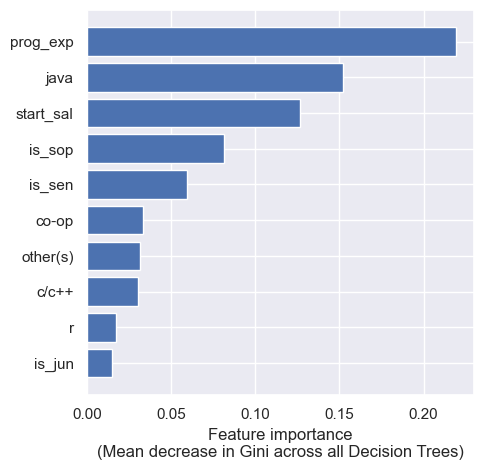

In [7]:
import seaborn as sns

sns.set()

plot_feat_import(x_feat_list, rf_clf.feature_importances_, limit=10)

Note that no direction is implied by a feature's importance:

`prog_exp` being high on this doesn't imply having more (or less) progreamming experience produces better chances at knowing python.  It could be that there are some `prog_exp` ranges which make it more likely (such as `prog_exp` being between 5-8 being more (or less) likely to produce a student with python experience) ... decision trees can re-use a feature in multiple nodes; all this tells us is that `prog_exp` was the most important feature for determining if a student has any python experience. 

## Nobody cares which features are important in a classifier that doesn't work ...
Before showing a plot / analysis like the above, provide a confusion matrix which demonstrates that the classifier works, and doing it (as always) via cross validation is important:

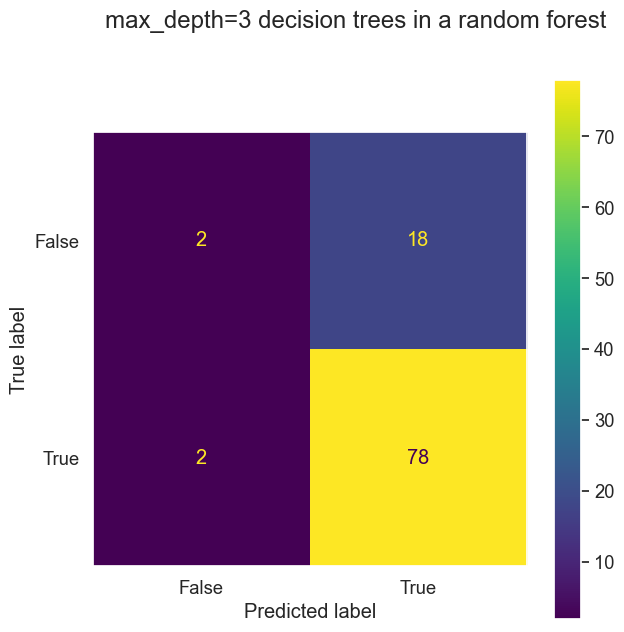

In [8]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from sklearn import tree
import seaborn as sns

n_splits = 10
max_depth = 3

# initialize k fold
skfold = StratifiedKFold(n_splits=n_splits)

# initialize random forest
rf_clf = RandomForestClassifier(max_depth=max_depth, n_estimators=1000)

# initialize y_pred, stores predictions of y
y_pred = np.empty_like(y)

for train_idx, test_idx in skfold.split(x, y):
    # get training data
    x_train = x[train_idx, :]
    y_train = y[train_idx]
    
    # get test data    
    x_test = x[test_idx, :]
    
    # fit data
    rf_clf = rf_clf.fit(x_train, y_train)
    
    # estimate on test data
    y_pred[test_idx] = rf_clf.predict(x_test)

y_feat_list = np.array(['False', 'True'])

# build and plot confusion matrix
sns.set(font_scale=1.2)
conf_mat = confusion_matrix(y_true=y, y_pred=y_pred)
conf_mat_disp = ConfusionMatrixDisplay(conf_mat, display_labels=y_feat_list)
conf_mat_disp.plot()
plt.gcf().set_size_inches(7, 7)
plt.grid(False)
plt.suptitle('max_depth=3 decision trees in a random forest');

So, our Random Forest classifier does a **great** job of correctly identifying students who have programming experience, but a **terrible** job of identifying those who don't. This is **not** a good classifier, because while the accuracy and sensitivity are relatively high, the specificity is very low.

In [9]:
def get_acc_sens_spec(y_true, y_pred, verbose=True):
    """ computes sensitivity & specificity (assumed binary inputs)

    Args:
        y_true (np.array): binary ground truth per trial
        y_pred (np.array): binary prediction per trial

    Returns:
        acc (float): accuracy
        sens (float): sensitivity
        spec (float): specificity
    """
    # line below stolen from sklearn confusion_matrix documentation
    tn, fp, fn, tp = confusion_matrix(y_true.astype(bool),
                                      y_pred.astype(bool),
                                      labels=(0, 1)).ravel()

    # compute sensitivity
    if tp + fn:
        sens = tp / (tp + fn)
    else:
        sens = np.nan

    # compute specificity
    if tn + fp:
        spec = tn / (tn + fp)
    else:
        spec = np.nan
        
    # compute acc
    acc = (tp + tn) / (tn + fp + fn + tp)

    return acc, sens, spec

In [10]:
get_acc_sens_spec(y, y_pred)

(0.8, 0.975, 0.1)

## Why not just compute Gini reduction on a single decision tree?

Given a single decision tree, we can quantify a feature's importance as the reduction in Gini produced across all the nodes which utilize this feature.  That should work, right?

What if two features are correlated?  A feature's importance can be "split" between some other correlated features.
- Example: What does it take to succeed in professional basketball?
    - height
    - weight
    - shoe size
    - hand span
    - hours spent playing basketball as a child
    
With Random Forests, a variety of different trees can provide insight into how each feature helps classification performance by itself.  Now we can see why we had such a counter-intuitive construction of a Random Forest:

Each tree in a Random Forest has limited access to:
- samples
    - some samples may be withheld from each tree's training by sampling
- features
    - we restrict a random forest to choose from a random subset of features in each node

## Lecture Break/Practice 1
### Solution in `day16_lecturebreaksols.ipynb`

1. Build a Random Forest Classifier which classifies whether a potential speed dater will find a match or not. Use `max_depth = 4` and 10-fold cross validation.
1. Print a confusion matrix which estimates how well the classifier performs on new speed daters.  Qualitatively describe if your classifier is a useful tool to a non-technical expert.
    - If we're estimating performance on new samples we must cross validate (see above)
1. Print a bar plot (`plot_feat_import()`) to describe which features are most useful for classification.  Qualitatively describe if these most important features are meaningful. In other words:
    - If the classifier performs well, we care about which features helped it work
    - If the classifier doesn't perform well, we don't care which features helped it "work"

In [11]:
# these data were taken and cleaned from: 
# https://www.kaggle.com/datasets/whenamancodes/speed-dating?select=Speed+Dating+Data.csv
df_speeddat = pd.read_csv('Speed Dating Data.csv')
df_speeddat.dropna(how='any', inplace=True)
df_speeddat.head()

,gender,match,samerace,age_o,pf_o_att,pf_o_sin,pf_o_int,pf_o_fun,pf_o_amb,pf_o_sha,...,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga
0,0,0,0,27.0,35.0,20.0,20.0,20.0,0.0,5.0,...,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0
1,0,0,0,22.0,60.0,0.0,0.0,40.0,0.0,0.0,...,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0
2,0,1,1,22.0,19.0,18.0,19.0,18.0,14.0,12.0,...,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0
3,0,1,0,23.0,30.0,5.0,15.0,40.0,5.0,5.0,...,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0
4,0,1,0,24.0,30.0,10.0,20.0,10.0,10.0,20.0,...,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0


Our target feature (y) is:
- `match`: whether the speed date resulted in another date `0=no match` and `1=yes match`
    
The input feature list (x) includes:
- `gender`: the self-identified gender, in these data there are only `0=male` and `1=female` and there is no information on the gender of the partner
- `samerace`: if the speed dater is the same race as their parter (`0=no` and `1=yes`)
- `age_o`: age of the partner
- `pf_o_att` through `pf_o_sha`: the partner's rating of importance for qualities (attractiveness, sincerity, intelligence, funny, ambition, shared intrest)
- `attr_o` through `shar_o`: the partner's rating of the **speed dater** in each quality
- `age`: the age of the speed dater
- `sports` through `yoga`: the speed dater's level of interest in each activity

In [12]:
df_speeddat.columns

Index(['gender', 'match', 'samerace', 'age_o', 'pf_o_att', 'pf_o_sin',
       'pf_o_int', 'pf_o_fun', 'pf_o_amb', 'pf_o_sha', 'attr_o', 'sinc_o',
       'intel_o', 'fun_o', 'amb_o', 'shar_o', 'age', 'sports', 'tvsports',
       'exercise', 'dining', 'museums', 'art', 'hiking', 'gaming', 'clubbing',
       'reading', 'tv', 'theater', 'movies', 'concerts', 'music', 'shopping',
       'yoga'],
      dtype='object')

In [13]:
# I will get you started by building the feature lists
x_feat_list = [df_speeddat.columns[0]] + list(df_speeddat.columns[2:])

# extract data from dataframe
x = df_speeddat.loc[:, x_feat_list].values
y = df_speeddat.loc[:, 'match'].values

# Regression

|                          | Input Features per sample | Output Features per sample | Supervised | Penguin Example                                                                       |
|:------------------------:|:-------------------------:|:--------------------------:|:----------:|---------------------------------------------------------------------------------------|
|           Classification | 1+ numerical features     | one categorical feature    | True       | Given `body_weight_g`, `flipper_length_mm` estimate `species`                         |
|               Regression | 1+ numerical features     | one continuous feature     | True       | Given `body_weight_g`, `bill_depth_mm` estimate `flipper_length_mm`                   |
|               Clustering | 1+ numerical features     | one categorical feature    | False      | Identify k groups of penguins which have similar `body_weight_g`, `flipper_length_mm` |
| Dimensionality Reduction | N numerical features      | < N numerical features     | False      | Find 2d vector which best represents all 4 of penguin's body/flipper/beak features    |

## Regression: Motivation

Can we predict a penguin's `flipper_length_mm` given their `body_mass_g`?

In [14]:
import seaborn as sns

df_penguin = sns.load_dataset('penguins')
df_penguin.dropna(axis=0, inplace=True)
df_penguin.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male


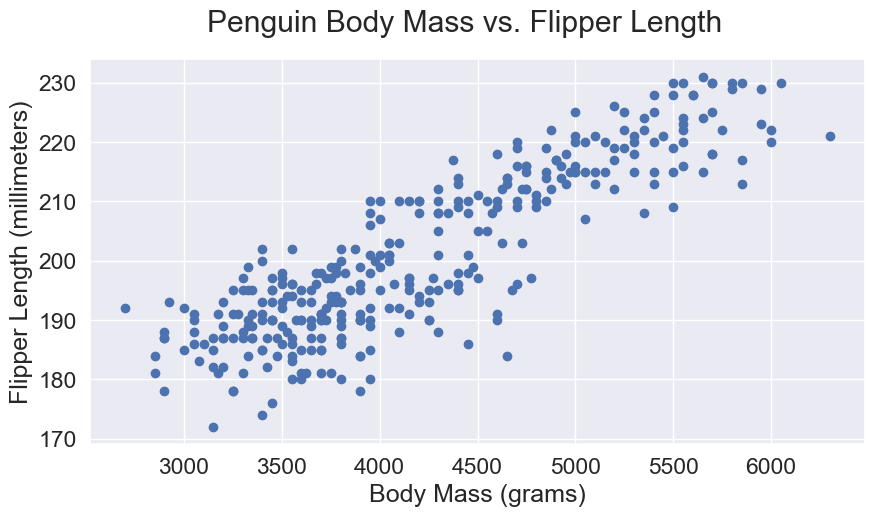

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=1.5)
plt.scatter(df_penguin['body_mass_g'], df_penguin['flipper_length_mm'])
plt.xlabel('Body Mass (grams)')
plt.ylabel('Flipper Length (millimeters)')
plt.suptitle('Penguin Body Mass vs. Flipper Length')
plt.gcf().set_size_inches(10, 5)

* Regression:
    - predicting a continuous number from input data
* We will predict the flipper length (mm) of penguins based on their body mass (g):
    * intuition from graph:
        - higher body mass -> longer flipper
    * use:
        - if the model is good, we could save time and get a good prediction of flipper length without having to measure

# What is the model?
## Simple linear regression

Simple linear regression seeks to find coefficients $b_0, b_1$ so that the function:

$$ \hat{y} = b_1 x + b_0 $$

is able to predict $y$ from $x$.

* $x$ is our input data 
    - (body mass of a penguin)
* $y$ is the outcome we're predicting 
    - (flipper length of a penguin)

To learn the function we 
1. observe paired observations of $(x, y)$ 
    - (this is akin to observing the scatter plot above)
1. find the $b_i$ coefficients which best map $x$ to $y$.
    - (this is akin to drawing a line through the scatter which "best" fits the points)

## Linear Regression: 2 point example (trivial)

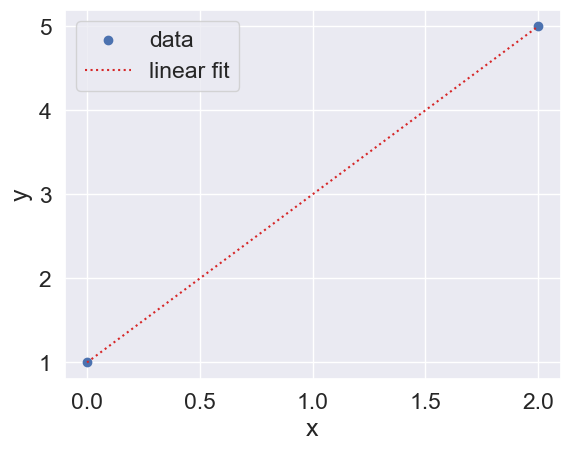

In [16]:
# points (0, 1) and (2, 5)
x = [0, 2]
y = [1, 5]

plt.scatter(x, y, label='data')

plt.plot(x, y, ls=':', color='tab:red', label='linear fit')
plt.xlabel('x')
plt.ylabel('y')
plt.legend();

## How do we find $b_1$ and $b_0$ that describe the line?

Remember our model:

$$ \hat{y} = b_1 x + b_0 $$

In [17]:
# calculate by hand on the board:
# if (0,1) and (2,5)
# 1 = b1 (0) + b0
# 5 = b1 (2) + b0
# 1 = b0
# 5 = b1 (2) + 1
# b1 = (5 - 1)/2 = 2
# so the line is y = 2x + 1

# What do $b_1$ and $b_0$ mean?

## Algebraic meaning:
- $b_1$ is the slope of the line
    - when x increases by 1, how much does y change?
- $b_0$ is the y-intercept of the line
    - when x=0, what value is y?
   
## Application meaning:
Returning to our penguin example where:
- x is the body mass (g)
- y is the flipper length (mm)


- because $b_1$ is the increase in y when x increases by 1
    - it represents the increase in flipper length (mm) when the body mass goes up by 1 g
- because $b_0$ is the value of y when x=0
    - it represents the flipper length (mm) our model predicts when a penguin has body mass of 0 g
        - **Note:** in practical terms, occasinoally the intercept is meaningless!

## Almost always, there is no $b_1$ and $b_0$ which "fit" every observation...

Specifying $b_1$ and $b_0$ is equivilent to specifying a straight line.  

Can we fit a straight line through all these observations?

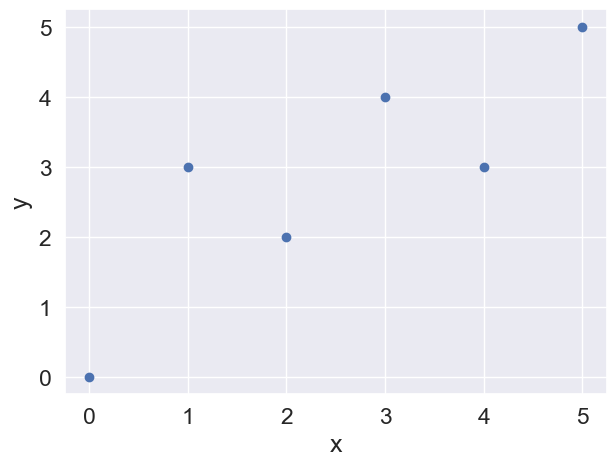

In [18]:
x = [0, 1, 2, 3, 4, 5]
y = [0, 3, 2, 4, 3, 5]

plt.scatter(x, y)
plt.gcf().set_size_inches(7, 5)
plt.xlabel('x')
plt.ylabel('y');

## ... lets find the line which "best" fits these points

### In this case:
- ground truth: 
    - $y_i$ is the y position sample i (observed)
- estimates: 
    - $\hat{y}$ is the estimated y position of sample i

### How to choose $b_i$ when data can't be fit with a straight line
1. Build some model of the data
    - $b_1 x + b_0 = \hat{y}$
    - remember the $b_i$ coefficients define the position of the line above
1. Quantify what a "good" model is
    - We want to minimize average distance from predicted y to observed y
1. `.fit()` the model parameters to maximize how "good" the model is
    - Choose $b_0, b_1$ to draw a line which is as close as possible to all the points
        - "as close as possible" = minimize average distance from predicted y to observed y

### Mean of Squared Errors (MSE)
Before formally defining **Mean of Squared Error (MSE)**, lets build our intuition of it:
- MSE measures how closely a line (i.e. $b_1, b_0$) comes to all observations $(x, y)$
- MSE is 0 when the line goes through all points exactly
    - in other words, some $b_1, b_0$ has, for every pair $(x, y)$:
    $$\hat{y} = b_1 x + b_0 = y $$
    - our trivial 2 observation example is like this, as will be all 2 observation data sets
- MSE is large when the line is far from many pairs $(x, y)$

**The best line $(b_1, b_0)$ is the one which minimizes MSE**

In [19]:
import numpy as np

def get_mse(y_true, y_pred):
    # calculate the mean squared distance between the predicted and actual y
    return np.mean((y_pred - y_true) ** 2)

def show_fit(x, y, slope, intercept):
    plt.figure()
    
    # transform the input data into numpy arrays and flatten them for easier processing
    x = np.array(x).ravel()
    y = np.array(y).ravel()
    
    # plot the actual data
    plt.scatter(x, y, label='data')
    
    # compute linear predictions 
    # x is a numpy array so each element gets multiplied by slope and intercept is added
    y_pred = slope * x + intercept
    
    # plot the linear fit
    plt.plot(x, y_pred, color='black',
             ls=':',
             label='linear fit')
    
    # for each data point plot the error
    for idx, (x_i, y_i) in enumerate(zip(x, y)):
        plt.plot([x_i, x_i], [y_i, slope * x_i + intercept], 
                 ls='--', lw=3, color='tab:red',
                 label='error' if idx == 0 else "")
    
    plt.legend()
    
    plt.xlabel('x')
    plt.ylabel('y')
    
    # print the mean squared error
    y_pred = slope * x + intercept
    mse = get_mse(y_true=y, y_pred=y_pred)
    plt.suptitle(f'y_hat = {slope:.2f} * x + {intercept:.2f}, MSE = {mse:.3f}')
 

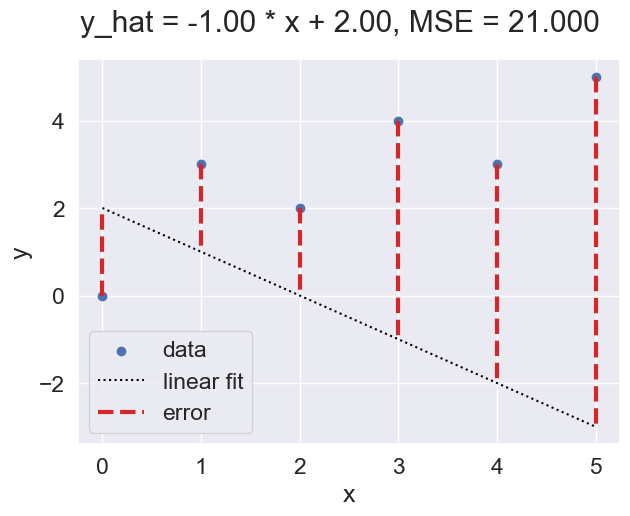

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=1.5)

x = [0, 1, 2, 3, 4, 5]
y = [0, 3, 2, 4, 3, 5]

show_fit(x, y, slope=-1, intercept=2)

plt.gcf().set_size_inches(7, 5)

The error of the j-th data point is the distance between our estimate $\hat{y}$ and the observed $y$.

$$\texttt{Error}_j = e_j = \hat{y}_j - y_j = b_1 x_j + b_0 - y_j$$

This definition "Mean of Squared Errors" is more than a name, its a recipe:

How to compute MSE:
1. Compute the error of every observation
1. Square each error
1. Compute average of all squared errors


## Is an MSE = 21 good for these points? i.e. is $\hat{y} = -1 x + 2$ the best line?

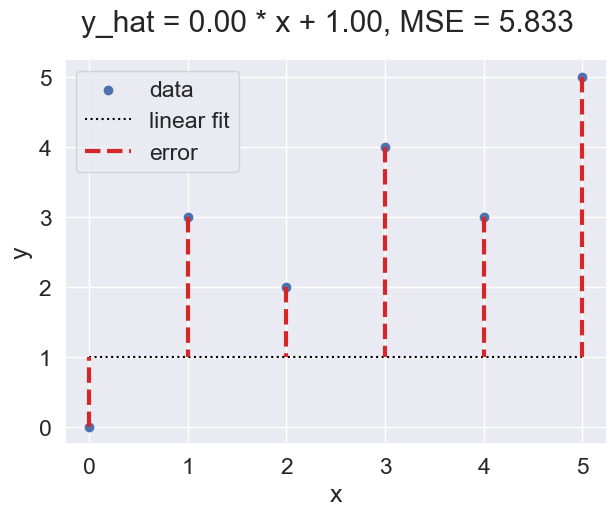

In [21]:
x = [0, 1, 2, 3, 4, 5]
y = [0, 3, 2, 4, 3, 5]
show_fit(x, y, 0, 1)

plt.gcf().set_size_inches(7, 5)

##  Looks like $\hat{y} = 0 x + 1$ is better, but is it the best?

In [22]:
# can calculate the MSE "by hand" easily here
error = np.array([1, -2, -1, -3, -2, -4])
error_sq = error ** 2
error_sq

array([ 1,  4,  1,  9,  4, 16])

In [23]:
mse = np.mean(error_sq)
mse

5.833333333333333

### Formal definition of MSE

$$
    MSE = \frac{1}{n}\sum_{j} {(\hat{y}_j - y_j)^2} = \frac{1}{n} \sum_{j} e_{j}^2
$$

where 
- $(x_j, y_j)$ are the paired observations
- n is the total number of paired observations
- $j$ is the observation index 
    - (first observation is 0, next is 1, ...)

## How can we avoid guessing and checking and find the best $b_0, b_1$?

We can use the `LinearRegression` function from `sklearn`, however we have to be a little careful. Something like this:

```python
from sklearn.linear_model import LinearRegression

x = np.array([0, 1, 2, 3, 4, 5])
y = np.array([0, 3, 2, 4, 3, 5])

reg = LinearRegression()
reg.fit(x, y)
slope = reg.coef_[0]
intercept = reg.intercept_
```

yields

    ValueError: Expected 2D array, got 1D array instead:
    array=[0 1 2 3 4 5].
    Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
    
Because the input $x$ of all our sklearn models must have shape (n_samples, n_features) but:


In [24]:
x = np.array([0, 1, 2, 3, 4, 5])
x.shape

(6,)

this is a 1d array, sklearn can't identify whether its:
- a single sample with 6 distinct features? (no)
- 6 distinct samples each with one feature? (yes)

In [25]:
x = x.reshape((6, 1))
print(x)
x.shape

[[0]
 [1]
 [2]
 [3]
 [4]
 [5]]


(6, 1)

In [26]:
from sklearn.linear_model import LinearRegression

x = np.array([0, 1, 2, 3, 4, 5]).reshape((6, 1))
y = np.array([0, 3, 2, 4, 3, 5])

# initialize sklearn model
reg = LinearRegression()

# fit the model
reg.fit(x, y)

# same as b_1
slope = reg.coef_[0]

# same as b_0
intercept = reg.intercept_

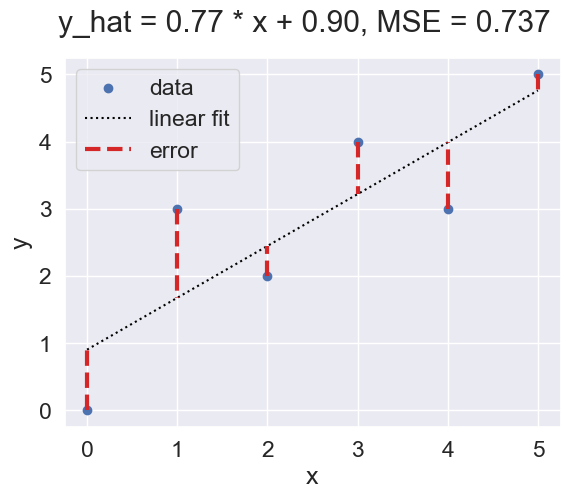

In [27]:
show_fit(x, y, slope, intercept)

So, How can we avoid guessing and checking and find the best $b_0, b_1$? We use `LinearRegression` function from `sklearn`.

Another question arises, however:

## What is the relationship between MSE and the sample variance of y?

Remember,
$$
    MSE = \frac{1}{n}\sum_j{( \hat{y_j} - y_j)^2}
$$

Look familiar?
$$\sigma^2 = \frac{1}{n}\sum_j{(\bar{y} - y_j)^2} $$
where $\bar{y}$ is the mean of our observed samples of $y$.


**Sample variance is the MSE of a line which predicts each $\hat{y}_j = \bar{y}$**

What kind of line would give the same prediction (the sample mean) for each sample?
- a horizontal line at the sample mean:

2.4722222222222228

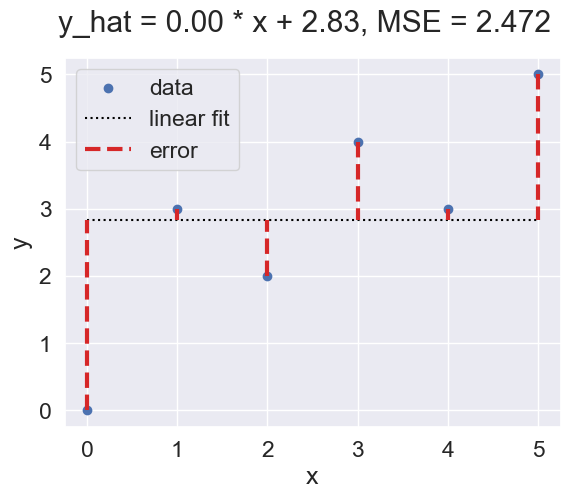

In [28]:
x = np.array([0, 1, 2, 3, 4, 5])
y = np.array([0, 3, 2, 4, 3, 5])
y_sample_mean = y.mean()
show_fit(x, y, slope=0, intercept=y_sample_mean)

np.var(y)

## An Intuition Honing Example: MSE and Variance of Y

Whats the minimum MSE of predicting $\hat{y} = b_1 x + b_0$ where:
- y = stock price increase on a given day
- x = number of coffees consumed by CEOs parents on the same day

1. As x increases, we don't observe changes in y
    - assume: x and y uncorrelated
1. Therefore, slope = $b_1 = 0$
1. To minimize MSE our best y prediction is to assign intercept = $b_0 = \bar{y}$
1. From above, an estimate of MSE of this model is sample variance: `np.var(y)`

# MSE and Variance: The Punchline

    MSE = variance in y unexplained by model

This definition suggests that we might "factor" the variance of Y into two components:
    

    total variance of y = variance in y explained by model + variance in y unexplained by model
                        = variance in y explained by model + MSE

## $R^2$ is the percentage of variance of y can be explained by the model

"Algebraic" motivation

    var y explained by model / total var y = (total var y - var y unexplained by model) / total var y
                                           = (total var y - MSE) / total var y
                                           = total var y / total var y - MSE / total var y
                                           = 1 - MSE / total var y

$$R^2 = 1-\frac{MSE}{\sigma_y^2}$$

$R^2$ is the percent of variance of y explained by x (under model)

Intuition:
- $R^2 = 0$
    - x, using this model, doesn't explain any of the variance of y
- $R^2 = .5$
    - x, using this model, explains half the variance of y
- $R^2 = 1$
    - x, using this model, explains all the differences in y

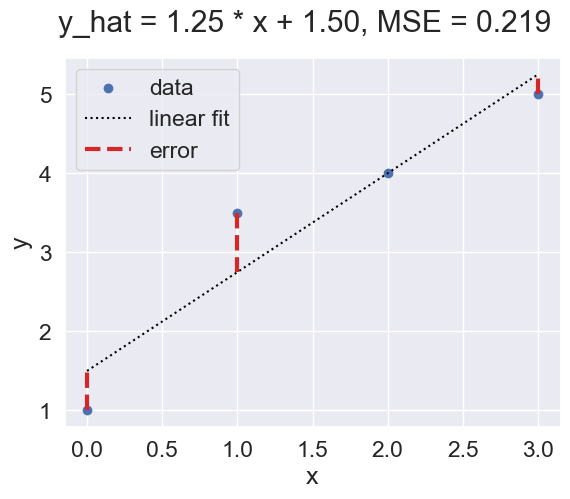

In [29]:
from sklearn.metrics import r2_score

x = np.array([0, 1, 2, 3]).reshape(-1, 1) # we can use -1 instead of 4 (good when we may not know the exact number of obs)
y = np.array([1, 3.5, 4, 5])

reg = LinearRegression()
reg.fit(x, y) 

# get the slope
slope = reg.coef_[0]

# get the intercept
intercept = reg.intercept_

y_pred = reg.predict(x) # same as y_pred = slope * x + intercept

show_fit(x, y, slope, intercept)

In [30]:
# computing R2 from our formula
R2 = 1 - (get_mse(y_pred, y)/np.var(y))

# computing R2 from sklearn (easy to work with, doesn't inspire our intuition with its use)
R2_easy = r2_score(y_true=y, y_pred=y_pred)

assert R2 == R2_easy, 'r2_score() doesnt agree with our formula'

print(R2)

0.8992805755395683


Our linear fit explains 89% of variance.

## Why is it $R^2$? What's $R$ then?


In [31]:
R = np.sqrt(R2)
R

0.9483040522636019

In [32]:
np.corrcoef(y, y_pred)

array([[1.        , 0.94830405],
       [0.94830405, 1.        ]])

# Another interpretation/way to calculate $R^2$
### Note: this is only true for simple linear regression (one x-feature, one y-feature), with regression with more than one x-feature (next class) this is not true

$$R^2 = \text{Correlation}^2$$
$$\text{Correlation} = sign(b_1)\sqrt{R^2}$$

**Note also:** this means that $R^2$ is not to be trusted if the relationship is not linear!

## Whats a 'good' $R^2$ value?

... it depends:

- if you're predicinting price changes in stock market: cross validated $R^2 = .01$ is fantastic!
    - if you keep using your model to make bets, you'll come out ahead, even if only slightly
- if you're predicting the flipper length of a penguin (y) given body mass (x): cross validated $R^2 = .01$ is not so great
    - knowing the body mass doesn't really help your prediction more than guessing would
    
    
More generally, $R^2$ should be interpreted in the context of the application.  Like Accuracy, its context dependent:

- baseball player who "accurately" gets base hit 50% of at-bats is better than any hitter to ever play the game
- pilot who "accurately" lands the plan without crashing 50% of the time might not be as celebrated ...

# Let's do it with the penguin data

Using the penguin data, Predict y=`flipper_length_mm` from x=`body_mass_g` by ...
1. `.fit()` a LinearRegression to predict y from x
1. visually inspect your results using `show_fit()`
1. print the following values to describe your prediction
    - slope 
    - intercept
    - mse
    - r2
1. Repeat the three steps above for each new x value below.  (Use a loop)
    - x=`bill_depth_mm`
    - x=`bill_length_mm`
    
Answer the following questions
1. Which of the three features, `body_mass_g`, `bill_depth_mm` or `bill_length_mm` best predicts changes in `flipper_length_mm`?
1. What does the slope of the best model mean in the context of the question (as if you were explaining to a non-technical audience)?
1. Can we trust these results?

In [33]:
from sklearn.linear_model import LinearRegression

x_names = ['body_mass_g', 'bill_depth_mm', 'bill_length_mm']
x_list = []
slope_list = []
intercept_list = []

for xl in x_names:
    x = np.array(df_penguin[xl]).reshape((-1, 1))
    x_list.append(x)
    y = np.array(df_penguin['flipper_length_mm'])

    # initialize sklearn model
    reg = LinearRegression()

    # fit the model
    reg.fit(x, y)

    # same as b_1
    slope_list.append(reg.coef_[0])

    # same as b_0
    intercept_list.append(reg.intercept_)

0.7620921573403914

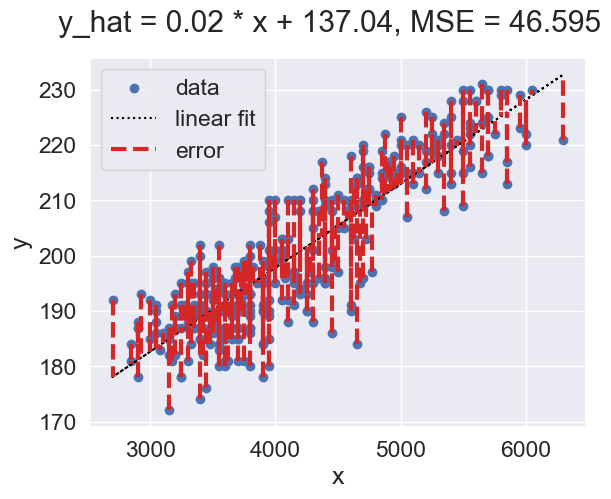

In [34]:
show_fit(x_list[0], y, slope_list[0], intercept_list[0])
y_pred_bmg = slope_list[0] * x_list[0] + intercept_list[0]
r2_score(y_true=y, y_pred=y_pred_bmg)

0.33384324435560986

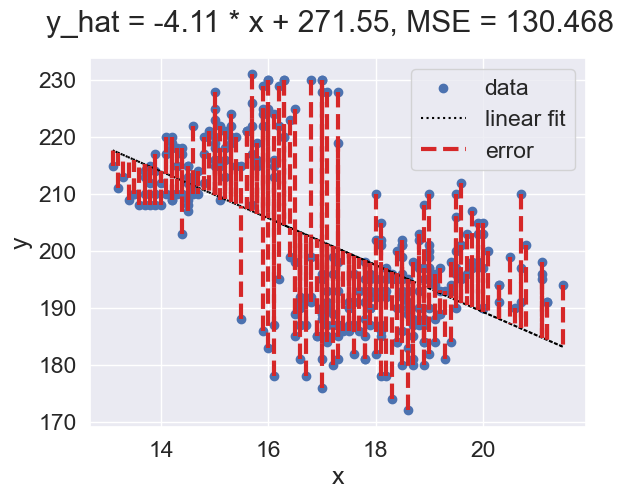

In [35]:
show_fit(x_list[1], y, slope_list[1], intercept_list[1])
y_pred_bdm = slope_list[1] * x_list[1] + intercept_list[1]
r2_score(y_true=y, y_pred=y_pred_bdm)

0.4265339132459688

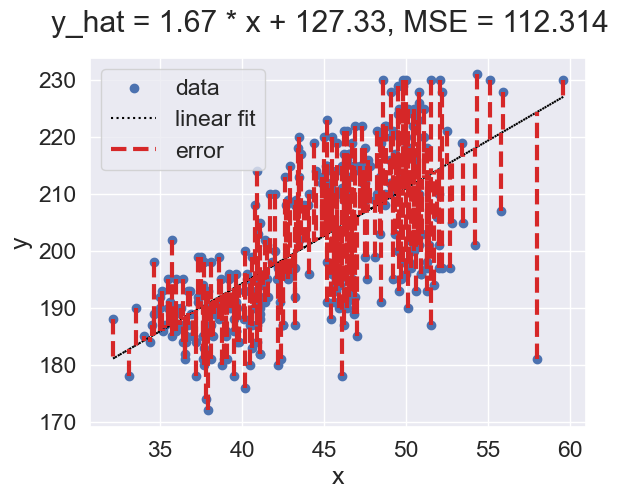

In [36]:
show_fit(x_list[2], y, slope_list[2], intercept_list[2])
y_pred_blm = slope_list[2] * x_list[2] + intercept_list[2]
r2_score(y_true=y, y_pred=y_pred_blm)

It appears that `body_mass_g` does the best job of predicting `flipper_length_mm` because it has the highest $R^2$ value. The slope can be interpreted as: every gram heavier a penguin is, we predict their flipper length to be .02 mm longer.

# So, we've built a model that seems to do a decent job of predicting `flipper_length_mm` with `body_mass_g`: Can we trust it?

There are two things we should do to be able to answer this question. The first we've discussed:

- **Cross Validation**: while we don't illustrate its use here (as I will ask you to implement it on your homework), we should perform k-fold cross validation to get a better understanding of $R^2$. It works exactly as it did for k-NN or Random Forests: convert the fold the data into k subsets. Iterate through, holding out one subset as a test set, fitting the linear regression on the others as a training set, predict the y-feature for the test set. The resulting $R^2$ will be a more trustworthy measurement of how well the model will predict new observations.  
- **Understand Assumptions**: there are certain assumptions we make about simple linear regression that we haven't discussed yet. Namely that the errors ($e_j$) not only are as small as possible on average (hence, minimizing the MSE) but also that they follow certain rules. In fact, there are three key assumptions that we must check in order to say we can trust these results:

1. The errors $e_j$ are independent
    - in other words, the observations themselves are independent; if they aren't then any results we get from the model may be misleading, because a trend we see may simply exist because some of the observations are related to each other
2. The errors $e_j$ vary constantly (also: linearity of the model)
    - in other words, if there is some pattern in how the errors behave, it indicates there is some pattern in the observations we have not taken into account; i.e. that the true relationship between x and y is not strictly linear (and this *is* **linear** regression, after all)
3. The errors $e_j$ follow a normal probability distribution
    - in other words, we expect most of the errors to be near zero, and an approximately equal number to be positive/negative
    
### You may NOT report results from conducting linear regression without checking these assumptions and verifying that they are met. If they are not met, you may still report the results, but you must acknowledge that they may be misleading

## Checking Independence
### We can check if the errors are indpendent by plotting them in the order of the observations; if we see any patterns, it suggests there is some dependency between observations

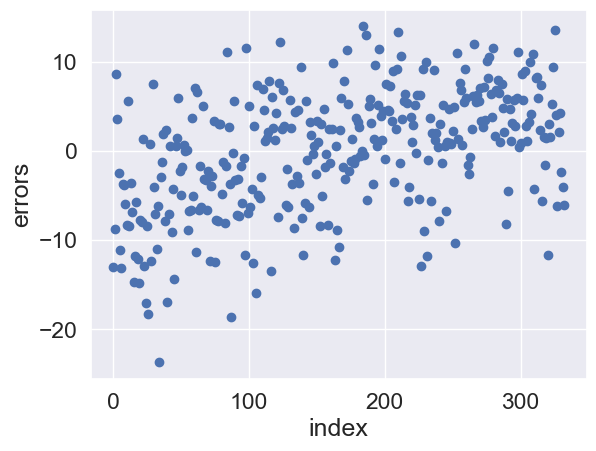

In [37]:
# plot a scatter plot of the errors in order
errors = y.reshape((-1,1)) - y_pred_bmg # need to reshape y because we manually calculated y_pred_bmg
plt.scatter(x = range(len(y)), y = errors)
plt.xlabel('index')
plt.ylabel('errors');

This is a little worrisome: residuals for earlier observations tend to be lower than residuals for later observations. Remember that the data are sorted: Adelie penguins first. This suggests that Adelie penguins are being predicted (on average) with **longer** flipper lengths (remember errors are $y - \hat{y}$) than the other penguins.

### How to fix?

It will depend on the situation. In this case, it might make sense to turn Species into dummy variables, and include them in a **multiple regression** (next class).

## Checking Constant Variance\Linearity
### We can check if the errors vary constantly by plotting them over the values of our x-feature; if we see any patterns, especially curving or tunnel/funnel shapes, it suggests the variance is non-constant or that the relationship is not truly linear

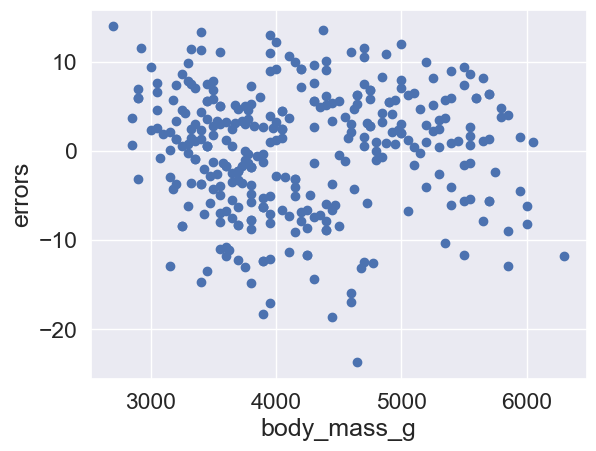

In [38]:
# plot a scatter plot of the errors over x
plt.scatter(x = x_list[0], y = errors)
plt.xlabel('body_mass_g')
plt.ylabel('errors');

There seems to be a fairly random scatter as we move from left to right, without much curving/funneling/tunneling. In this case, it seems okay.

#### How to fix?

It is quite a bit harder to fix this issue when it arises; there are some more complicated ways to try to address it. One of the simpler ways is to transform the y-feature, but choosing what transformation to use is not trivial! We don't have time to discuss it in this class, but you may encounter it in the future. In some cases, for example when there is curving, it may also be fixed by including polynomial terms (**polynomial regression**, next time).

## Checking Normality
### We can check if the errors are normally distributed by plotting their observed quantiles against the expected quantiles of a theoretical normal distribution; if we see an approximately straight, 45 degree line, it means our errors are normal, if it's really off, there's a problem!

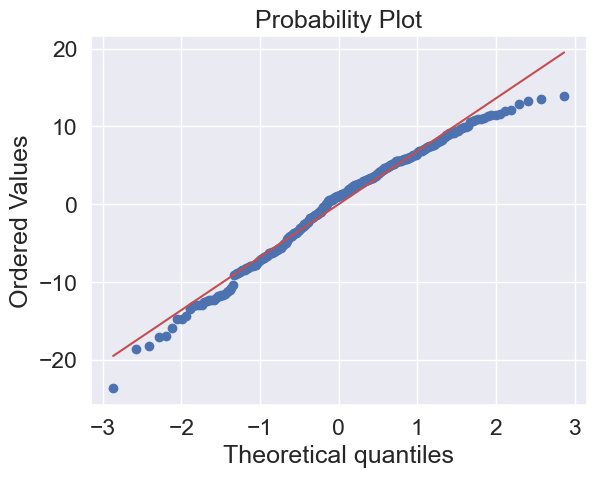

In [39]:
# the two modules below will help us plot our error QQ probabiliy plot (QQ = Quantile-Quantile)
# may need to pip install scipy
import pylab as py
import scipy.stats as stats

# unfortunately, .probplot requires us to reshape the array back to a single dimension
# only have to do this because we calculated y_pred_bmg manually; if we had used reg.predict(x), wouldn't need to
stats.probplot(errors.reshape((-1,)), dist="norm", plot=py)
py.show()

This may be a bit tricky to assess; my instinct tells me it's not too bad, but we can also see that the plot indicates the distribution of errors are slightly **left skewed** (longer tail on the left). We can verify this with a histogram:

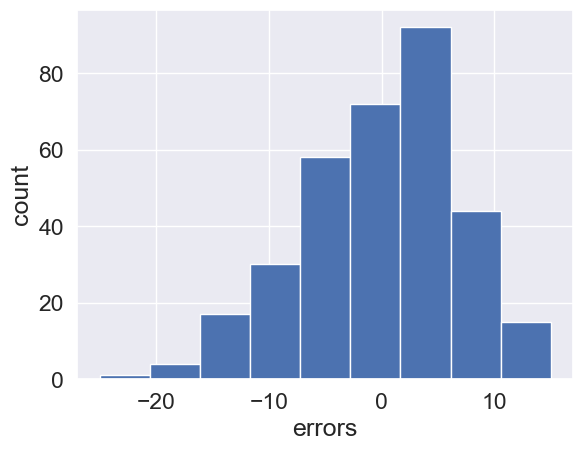

In [40]:
# set the bins based on the range of the errors
bins = np.linspace(-25, 15, 10)

# use matplotlib to make the histogram
plt.hist(errors, bins=bins)
plt.xlabel('errors')
plt.ylabel('count');

#### How to fix?

This can again be tricky. Transformations of the y feature may help again, or including more x features or polynomial features (multiple/polynomial regression), or changing the anticipated distribution of the y feature (**exponential regression**, next time). 

# (Likely next time) Lecture Break/Practice 2
### Solution in `day16_lecturebreaksols.ipynb`

Use the `evdataset.csv` from the Homework module on Canvas. Let us see if we can use linear regression to predict an electric vehicle's `Top Speed` (in kilometers per hour)  based on `Acceleration` (in seconds (time to go from 0 to 100 Km per hr)).

1. Use `LinearRegression()` to fit the data, get the slope and intercept, and `reg.predict(x)` to get the `y_pred` predictions
2. Use `show_fit()` to plot the graph, display the best fit line and MSE
    - Interpret the slope in the context of the problem
3. Use `r2_score()` to calculate $R^2$ and interpret it
4. Check the three assumptions of independence, constant variance, and normality
5. Make a recommendation on next steps; can we use this model to predict an EV's Top Speed? Should we try something else? Give up?


In [41]:
df_ev = pd.read_csv('evdataset.csv', index_col='id')
df_ev.head()

,Drive,Acceleration,Top Speed,Electric Range,Total Power,Total Torque,Battery Capacity,Charge Speed,Length,Width,Height,Wheelbase,Gross Weight
id,,,,,,,,,,,,,
1647,Rear,7.8,185,390,168,350,77.4,49,4515,1890,1580,2900,2495
1493,AWD,6.2,160,330,215,520,69.7,46,4684,1834,1701,2829,2580
1229,AWD,3.2,260,415,500,850,93.4,46,4963,1966,1381,2900,2880
1252,Rear,5.7,190,470,250,430,83.9,54,4783,1852,1448,2856,2605
1534,Rear,7.9,160,450,150,310,82.0,55,4261,1809,1568,2771,2300
